# BART hourly flowthrough visualization
## Overview
### Convert from hourly entrance exit data to flowthrough
* Build map (graph) of BART system using the Station and Sation_Map classes and a tab delimited file of adjacent stations
* Navigate graph with Dijkstra's algorithm in order to find shortest path between enrance and exit stations
* Add up individuals passing through each station in a given hour based upon shortest paths between their entrance and exit
* Calculate medians
* Normalize medians to largest for plotting purposes

### Plotting
* Draw Map of bay area as background
* Load in coordinate information to plot edges between stations
* Plot ridership data as a polygon on the edges (effectively a rotated barplot)
* Create gif out of a plot for each hour of the day

# Import Modules

In [594]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import math
import glob
import statistics
from matplotlib.pyplot import imread
import matplotlib.cbook as cbook
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
sns.set_style('whitegrid')

# Define classes and functions

In [156]:
class Station:
    def __init__(self, name):
        self.connections = {}       
        self.name = name 
    
    def add_connection(self, name, dist=None):
        if dist is None:
            con_dist = 1
        else:
            con_dist = dist
        self.connections[name] = con_dist
        
    def connection_exists(self, name):
        if connection in self.connections:
            return True
        return False

In [157]:
class Station_Map:
    def __init__(self):
        self.s_map = {}
        
    def add_station(self, station_name):
        '''
        Add station to the graph
        '''
        self.s_map[station_name] = Station(station_name)
        
    def station_exists(self, station_name):
        '''
        Check if station exists within the graph
        '''
        if station_name in self.s_map:
            return True
        else:
            return False
    
    def connect_stations(self, station_1, station_2):
        '''
        Connect two stations within the graph
        '''
        if not self.station_exists(station_1):
            self.add_station(station_1)
        if not self.station_exists(station_2):
            self.add_station(station_2)
            
        self.s_map[station_1].add_connection(station_2)
        self.s_map[station_2].add_connection(station_1)
        
    def find_path(self, station_1, station_2):
        '''
        Use Dijkstra's algorithm to find shortest path between two stations
        credit: https://stackoverflow.com/questions/22897209/dijkstras-algorithm-in-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
        '''
        def _deconstruct_path(tentative_parents, end):
            '''
            Reconstruct path used to get from station_1 to station_2
            '''
            if end not in tentative_parents:
                return None
            cursor = end
            path = []
            while cursor:
                path.append(cursor)
                cursor = tentative_parents.get(cursor)
            return list(reversed(path))
    
        #if start is end, return current station as path
        if station_1 is station_2:
            path = []
            path.append(station_1)
            return path
        
        # We always need to visit the start
        nodes_to_visit = {station_1}
        visited_nodes = set()
        # Distance from start to start is 0
        distance_from_start = {station_1: 0}
        tentative_parents = {}

        while nodes_to_visit:
            # The next node should be the one with the smallest weight
            current = min(
                [(distance_from_start[node], node) for node in nodes_to_visit]
            )[1]

            # The end was reached
            if current == station_2:
                break

            nodes_to_visit.discard(current)
            visited_nodes.add(current)

            edges = self.s_map[current].connections
            unvisited_neighbours = set(edges).difference(visited_nodes)
            for neighbour in unvisited_neighbours:
                neighbour_distance = distance_from_start[current] + \
                                     edges[neighbour]
                if neighbour_distance < distance_from_start.get(neighbour,
                                                                float('inf')):
                    distance_from_start[neighbour] = neighbour_distance
                    tentative_parents[neighbour] = current
                    nodes_to_visit.add(neighbour)

        return( _deconstruct_path(tentative_parents, station_2) )
    
    def nodes_to_edges(self, path):
        '''
        Convert a path of graph (s_map) nodes (stations) to edges (connections)
            Ex: edge between NBRK and DBRK returned as
            NBRK.DBRK
        '''
        edges = []
        for i, node in enumerate(path):
            if i+1 < len(path):
                edges.append( str(path[i]) + "." + str(path[i+1]) )
        return edges
    
    def find_path_edges(self, station_1, station_2):
        '''
        Use self.find_path and self.nodes_to_edges to return a path of edges rather than nodes
        '''
        path = self.find_path(station_1, station_2)
        return self.nodes_to_edges(path)
        

In [158]:
def Build_Subway_Map(adjacent_stations_file):
    '''
    Give this module a path to a tab delimited file containing all pairwise connections of adjacent stations. ie:
    station_AZ station_KL
    station_KL station_DS
    and it will build a map of all station connections
    '''
    station_map = Station_Map()
    
    adj_sta_fh = open(adjacent_stations_file)
    
    for line in adj_sta_fh:
        sline = line.strip().split()
        station_map.connect_stations(sline[0], sline[1])
        
    return station_map

In [727]:
def hourly_to_flowthrough(hourly_data_file, BART_map):
    '''
    Convert BART hourly entrance exit data to flowthrough data
    This part is messy. I used a dictionary for some reason but a pandas dataframe would probably be much easier to work with/subset downstream
    Caveats:
        Assumes riders take most efficent path through BART. Probably true in vast majority of cases.
        Assumes riders got on/off during the same hour. Probably not true a lot of the time but should only affect the resolution of the data and bias ridership towards exit times.
    '''
    #data stored in dictionary where each edge has number of riders flowthrough from that hour
    hours = {}
    dates = {}
    paths = {}
    
    hourly_fh = open(hourly_data_file)
    
    for line in hourly_fh:
        sline = line.strip().split(',')
        
        #columns labelled for clarity
        date = sline[0]
        hour = sline[1]
        start = sline[2]
        stop = sline[3]
        num_riders = sline[4]
        
        #Need to sum for each station for each hour of every day - calculate mean/median of daily hourly values
        
        #skip same station entrance + exits
        if start not in stop:
        
            if hour not in hours:
                hours[hour] = {}
                
            path = (str(start) + '.' + str(stop))
            if path not in paths:
                paths[path] = BART_map.find_path_edges(start, stop)
        
            for connection in paths[path]:
                if connection not in hours[hour]:
                    hours[hour][connection] = {}
                
                if date not in hours[hour][connection]:
                    hours[hour][connection][date] = 0
            
                hours[hour][connection][date] += int(num_riders)
                
    return hours
            

# Convert hourly to flowthrough

In [725]:
BART_map = Build_Subway_Map("/home/pwest/notebooks/BART/adjacent_stations.tsv")

In [728]:
raw_flowthrough = hourly_to_flowthrough("/home/pwest/notebooks/BART/date-hour-soo-dest-2017.csv", BART_map)

In [729]:
#Need to convert this to a datframe for simplicity

def calculate_medians(raw_flowthrough): 
    medians = {}
    for hour in raw_flowthrough:
        if hour not in medians:
            medians[hour] = {}
        for connection in raw_flowthrough[hour]:
            numbers = [raw_flowthrough[hour][connection][key] for key in raw_flowthrough[hour][connection]]
            medians[hour][connection] = statistics.median(numbers)
    return medians

In [730]:
medians = calculate_medians(raw_flowthrough)

# Plotting

In [522]:
class Connection:
    '''
    Intended to hold coordinate and color information for edges between stations. For plotting purposes
    '''
    
    def __init__(self, start, stop, color=None):
        
        if color is not None:
            self.color = color
        else:
            self.color = 'black'
        self.start = start
        self.stop = stop
        
        #Convert points to vector
        self.vector = np.array([stop[0] - start[0], stop[1] - start[1]])
        self.v_mag = np.linalg.norm(self.vector)
        self.v_dir = np.array([self.vector[0]/self.v_mag, self.vector[1]/self.v_mag] )
        
        self.x2 = 0
        self.x3 = 0
        self.y2 = 0
        self.y3 = 0

    def plt_points(self, distance):
        
        '''
        Converts raw barplot value to a 2d distance orthogonal to the orientation of the rotated barplot.
        Returns two points (used in conjunction with the self.start and self.stop) used for plotting the barplot as a polygon
        '''
        
        self.x2 = self.start[0] + (distance * self.v_dir[1])
        self.y2 = self.start[1] - (distance * self.v_dir[0])
        
        self.x3 = self.stop[0] + (distance * self.v_dir[1])
        self.y3 = self.stop[1] - (distance * self.v_dir[0])
        
        return [self.x2, self.y2], [self.x3, self.y3]
    

In [683]:
def Plot_Connection_Rect(connection, ridership, ax, patch_color=None):
    '''
    Plot flowthrough a station as a rotated bar plot
    '''
    
    if patch_color is None:
        patch_color = connection.color
    points =[]
    points.append(connection.stop)
    points.append(connection.start)
    points.extend(connection.plt_points(ridership))
    
    patch = plt.Polygon(points, color=patch_color)
    ax.add_patch(patch)

In [736]:
def Plot_Connection_poly(connection, ridership, ax, patch_color=None):
    '''
    Effectively the same as Plot_Connection_Rect except instead of being square, one edge has a point indicating directionality 
    '''
    
    if patch_color is None:
        patch_color = connection.color
    #Was originally using default orange and purple. This switches to BART colors
    if 'orange' in patch_color:
        patch_color = [86/255,155/255,216/255]
    elif 'purple' in patch_color:
        patch_color = [0,0,0]
    points =[]
    
    #Get points same as if plotting a rectangle
    points.extend(connection.plt_points(ridership))
    
    #Modify points on one end to form a triangle/arrowhead
    stop2 = []
    stop2.append( connection.vector[0] * 0.7 + connection.start[0] )
    stop2.append( connection.vector[1] * 0.7 + connection.start[1] )
    
    stop3 = []
    stop3.append( connection.vector[0] * 0.7 + points[0][0] )
    stop3.append( connection.vector[1] * 0.7 + points[0][1] )
    
    arrowhead = []
    arrowhead.append( connection.stop[0] + ((ridership/2) * connection.v_dir[1]) )
    arrowhead.append( connection.stop[1] - ((ridership/2) * connection.v_dir[0]) )
    
    plot_points = []
    plot_points.append(stop2)
    plot_points.append(connection.start)
    plot_points.append(points[0])
    plot_points.append(stop3)
    plot_points.append(arrowhead)
    
    patch = plt.Polygon(plot_points, color=patch_color)
    ax.add_patch(patch)

In [545]:
def Parse_Station_Coors(Station_Coors_File_Name):
    coors_fh = open(Station_Coors_File_Name)
    
    station_coors = {}
    
    for line in coors_fh:
        sline = line.strip().split()
        station_coors[sline[0]] = Connection([float(sline[1]), float(sline[2])], [float(sline[3]), float(sline[4])], sline[5])
        
    return station_coors     

In [731]:
station_coors = Parse_Station_Coors("/home/pwest/notebooks/BART/station_coors.tsv")

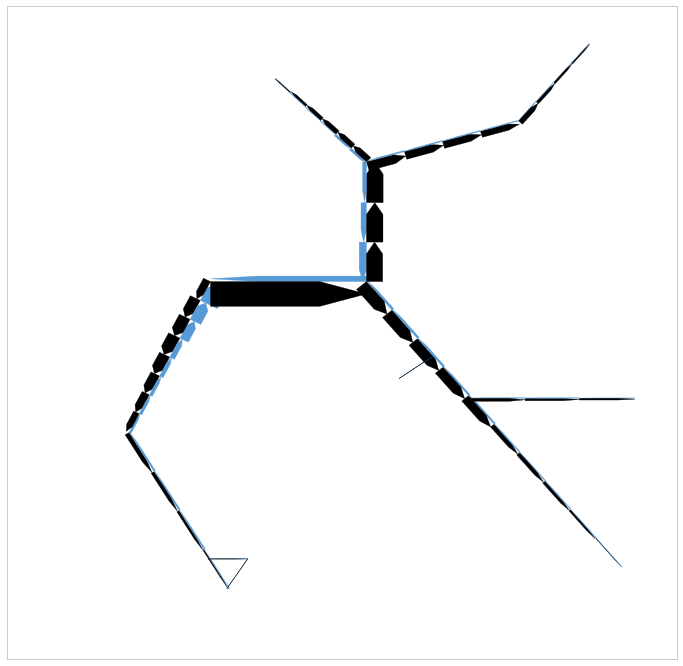

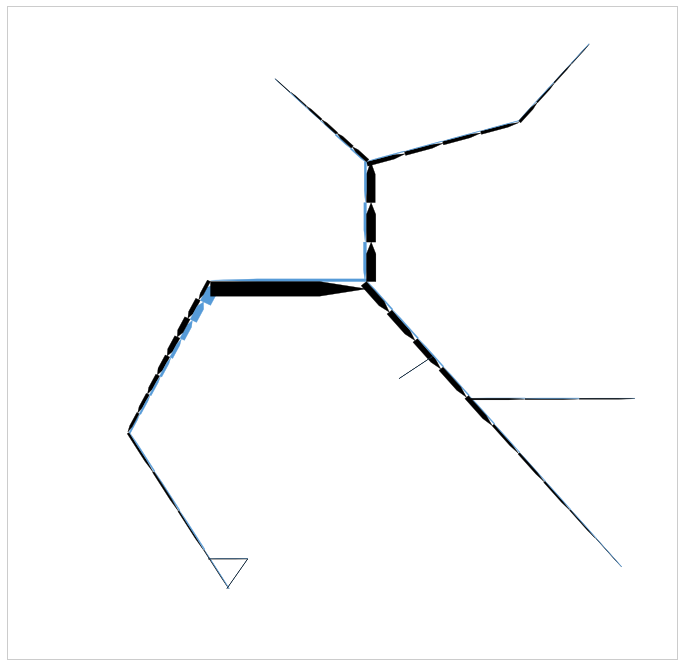

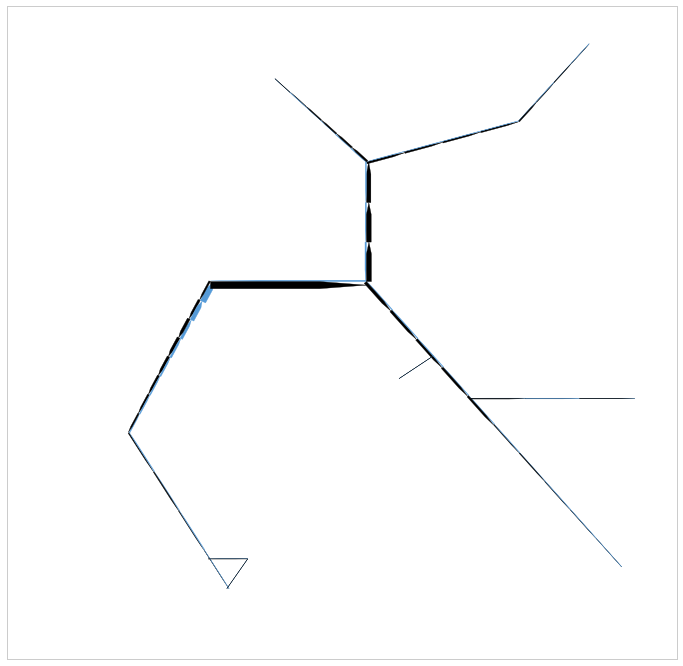

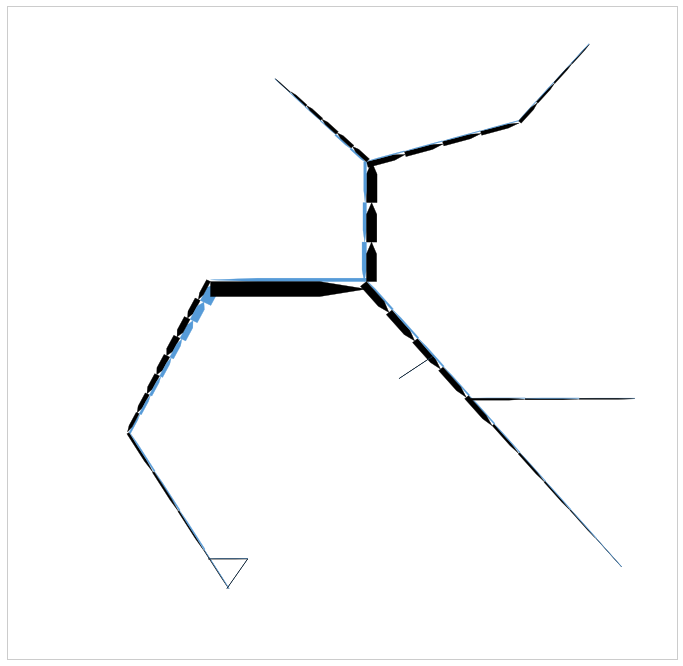

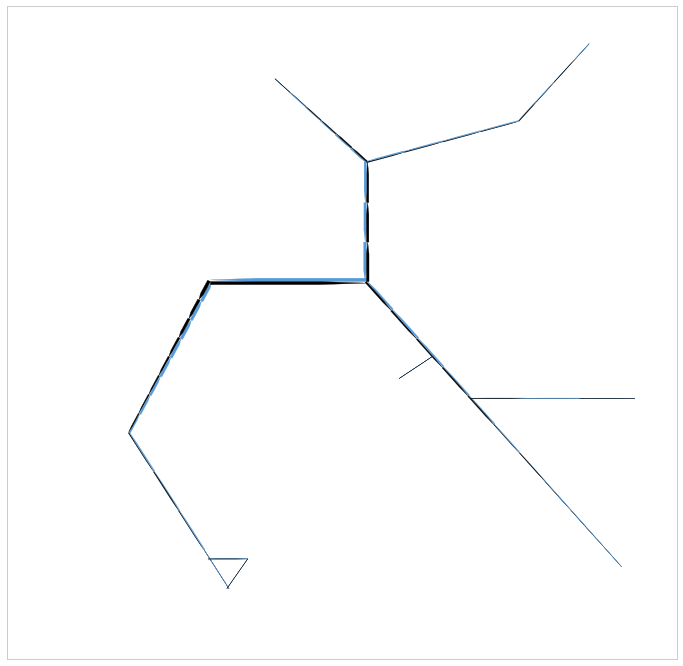

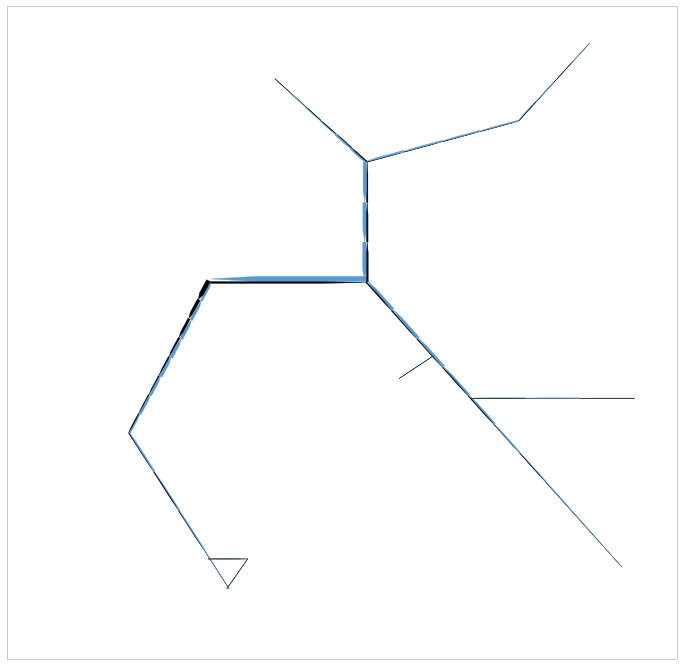

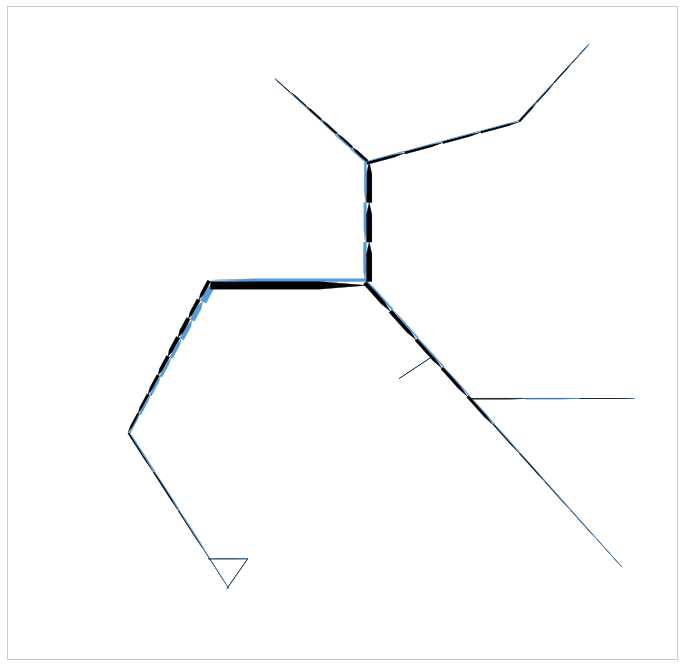

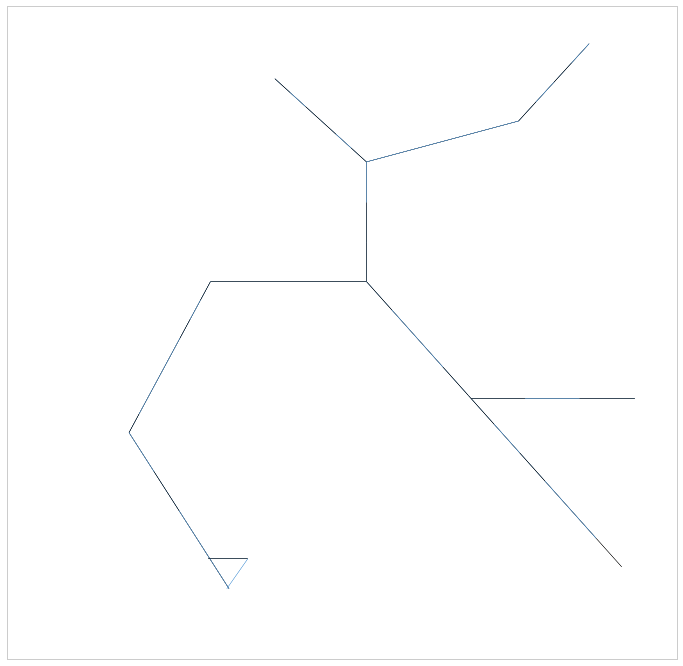

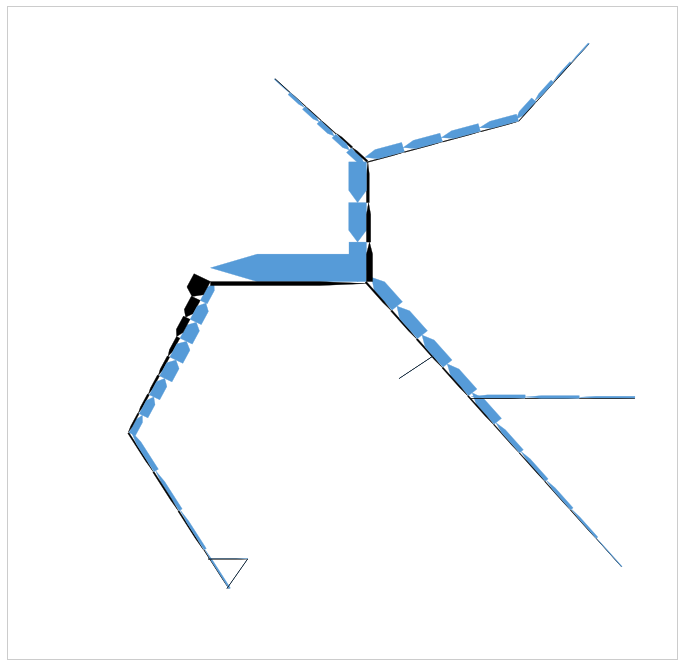

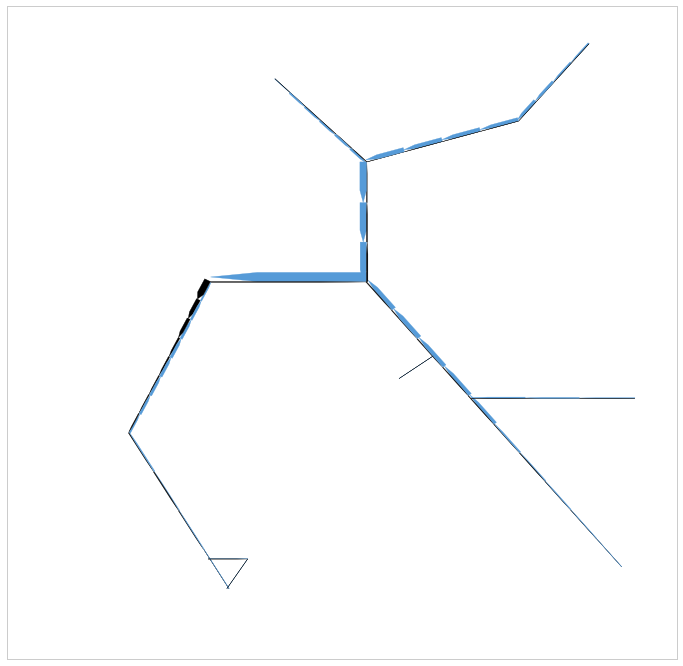

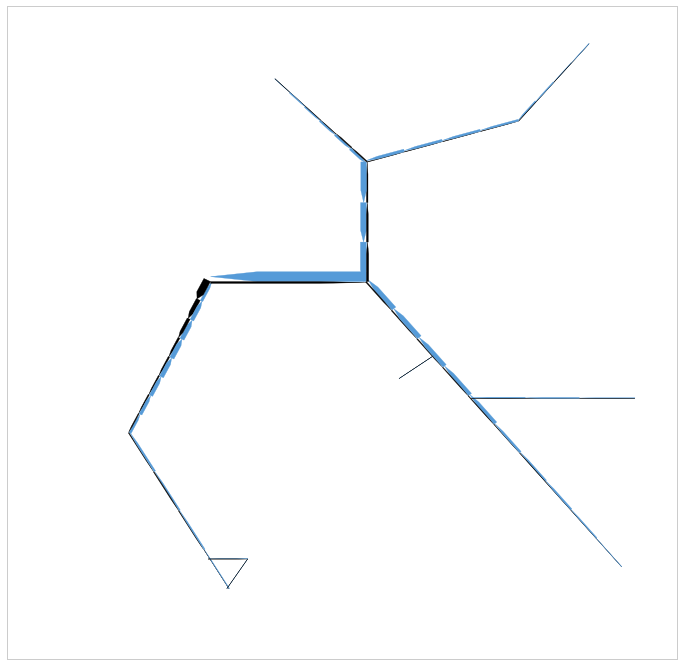

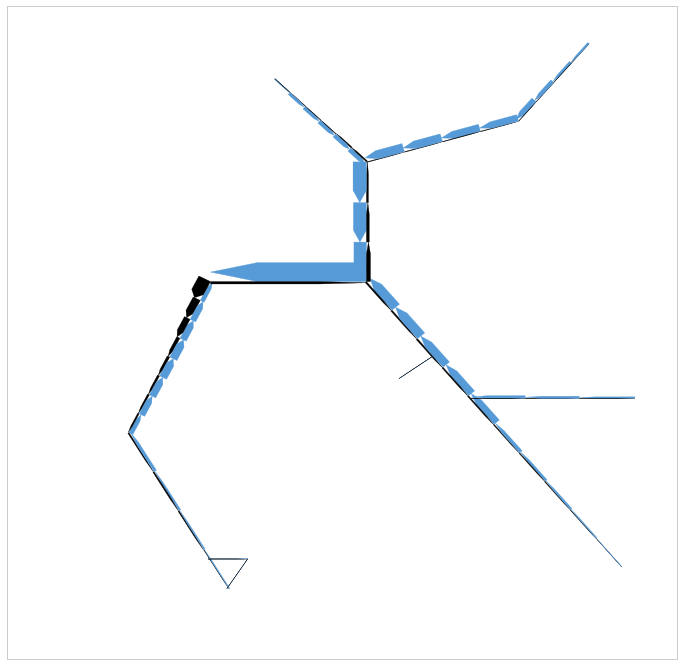

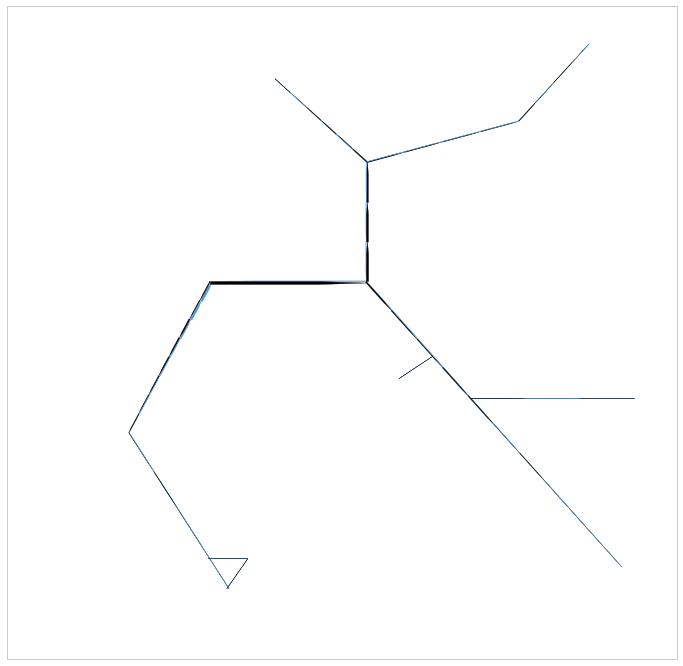

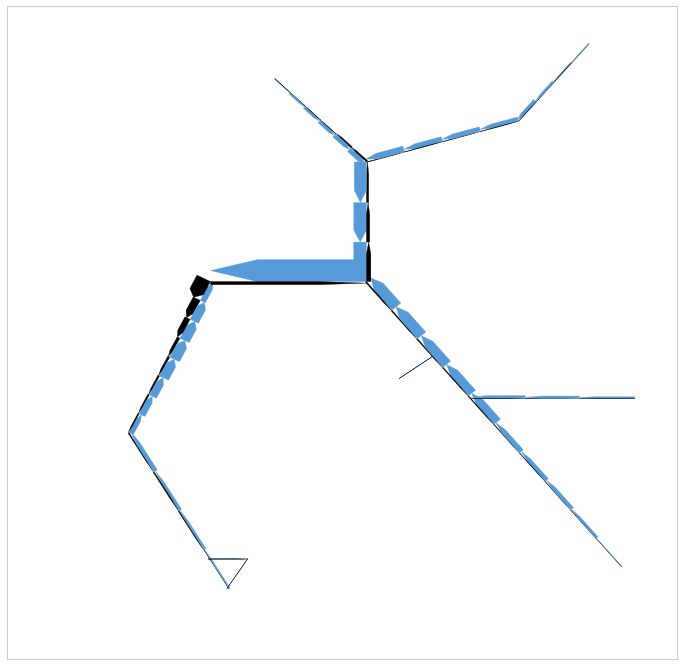

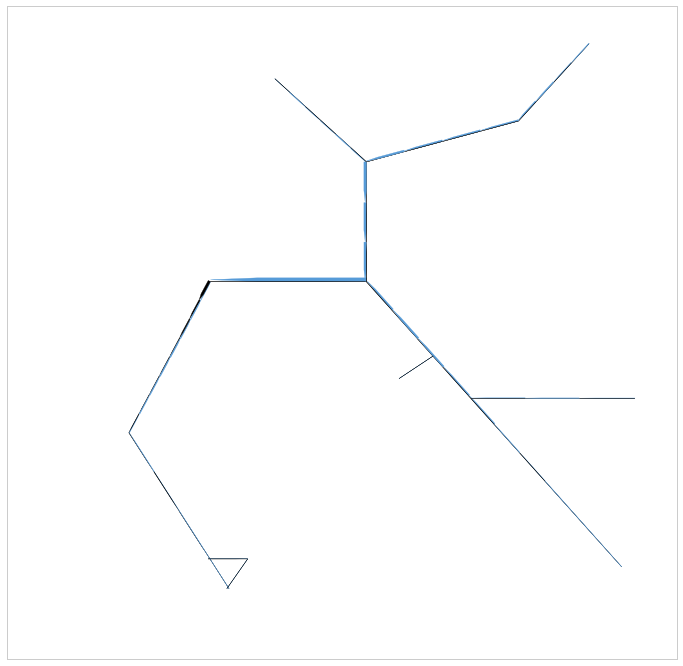

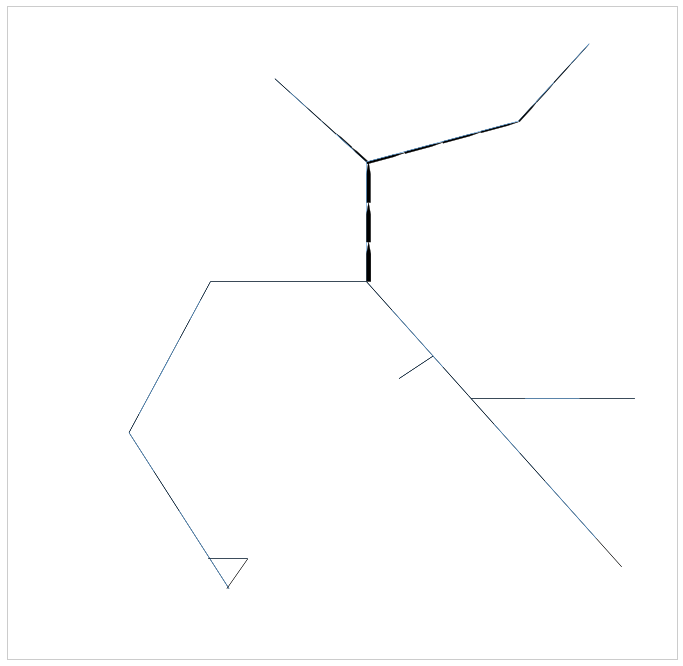

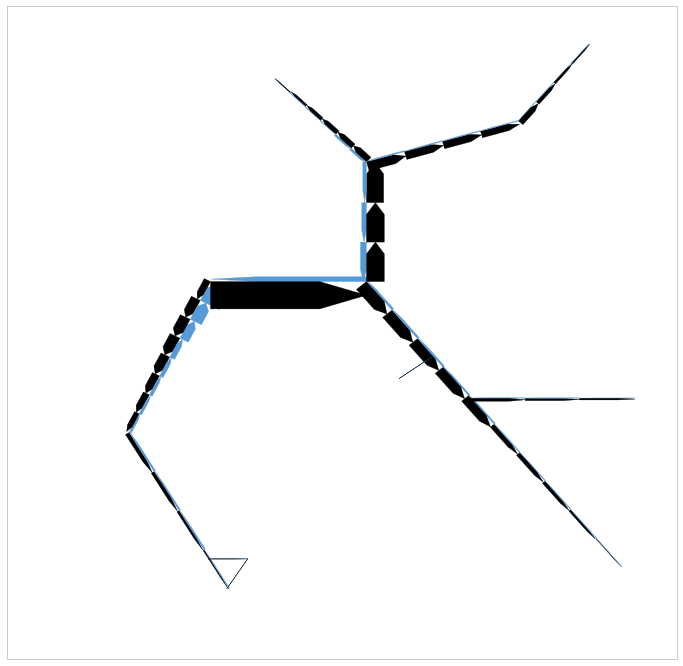

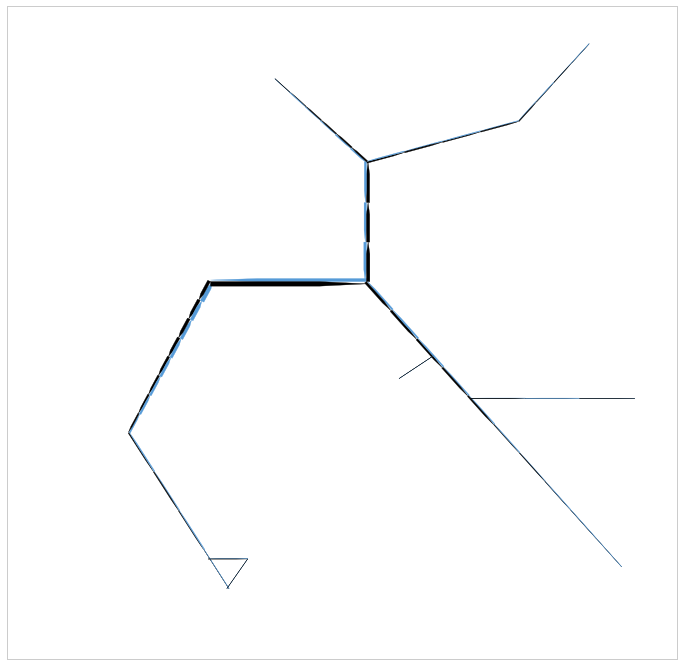

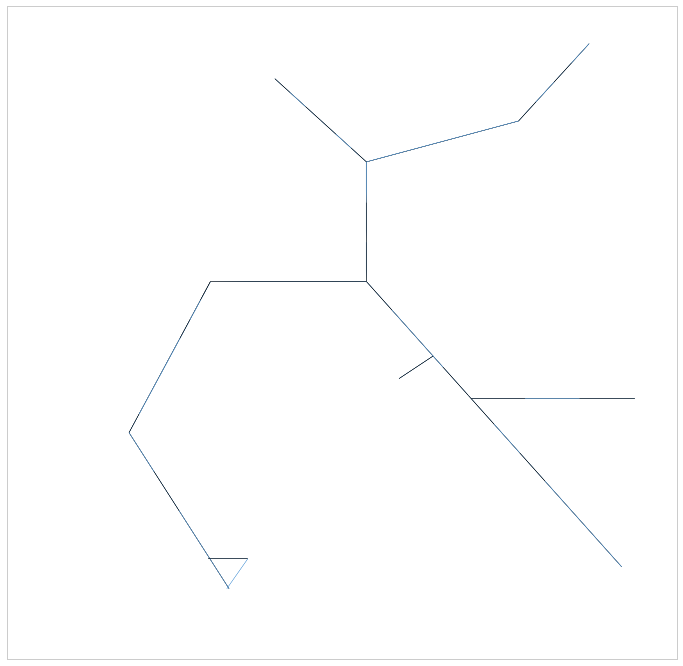

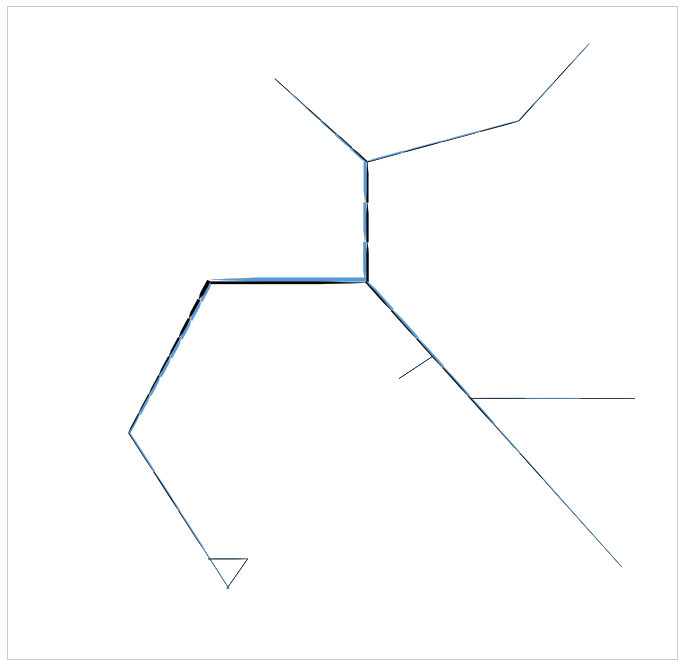

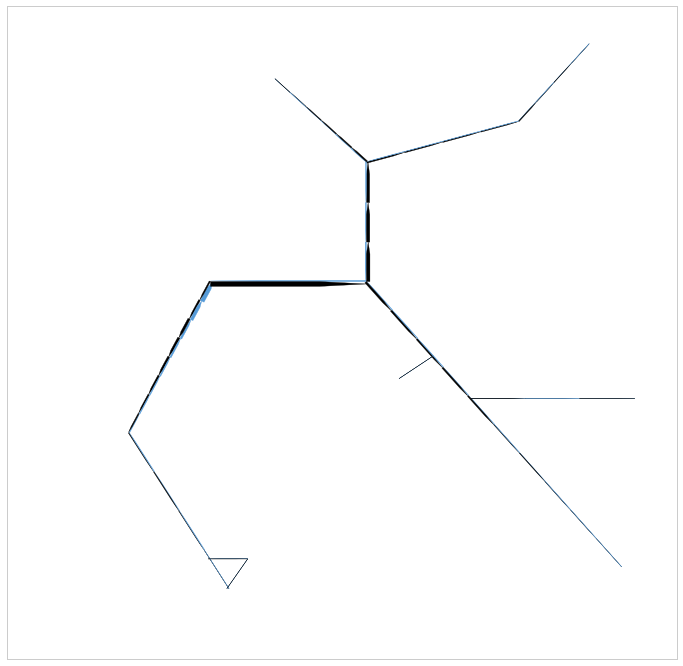

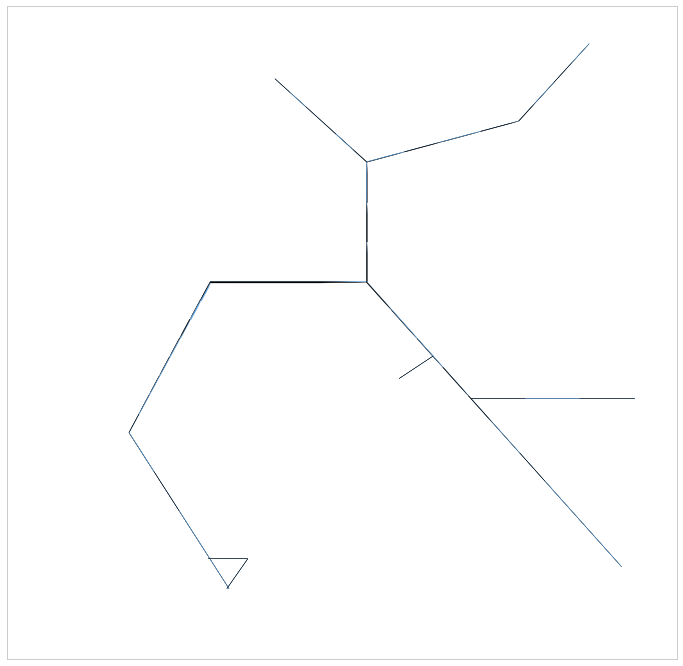

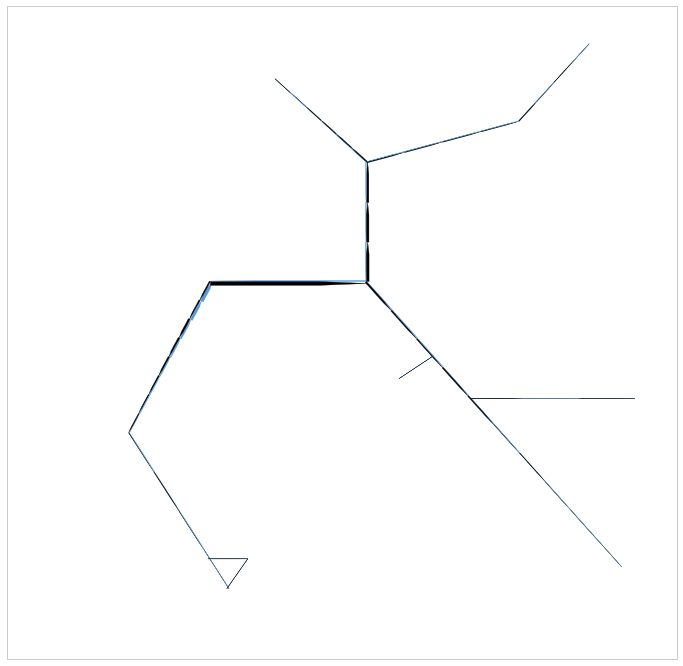

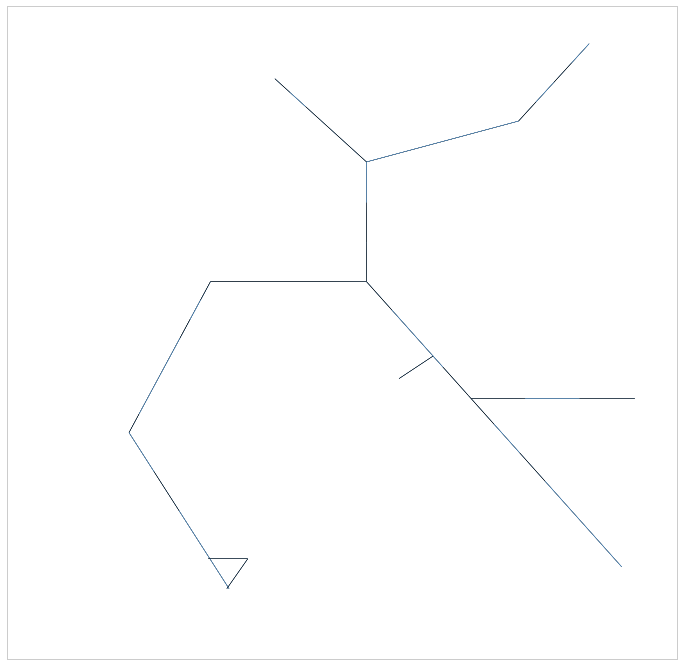

In [734]:
#Draw background map image and set up plot dimensions as image dimensions
for hour in medians:
    fig, ax = plt.subplots()
    #fig.set_tight_layout(True)

    #Draw map of Bay Area as background. Shut off for now, easier to add a day night cycle in photoshop with the map as a separate layer added in photoshop. 
    datafile = cbook.get_sample_data('/home/pwest/notebooks/BART/sanfrancisco02_bsimple.png')
    img = imread(datafile)
    #ax.imshow(img, zorder=0, extent=[0, 863, 0, 894])
    ax.set_xlim(0, 863)
    ax.set_ylim(0, 894)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.grid(False)

    temp = []
    for key in medians['9']:
        temp.append(medians['9'][key])
    nine_max = max(temp)

    for station in medians[hour]:
        Plot_Connection_poly(station_coors[station], medians[hour][station]/nine_max*30, ax)

    plt.gcf().set_size_inches(12, 12)
    plt.savefig("/home/pwest/notebooks/BART/BART_flowthrough_hour_%s.png" % hour, dpi=600, transparent=True)
    plt.show()

timestep 0


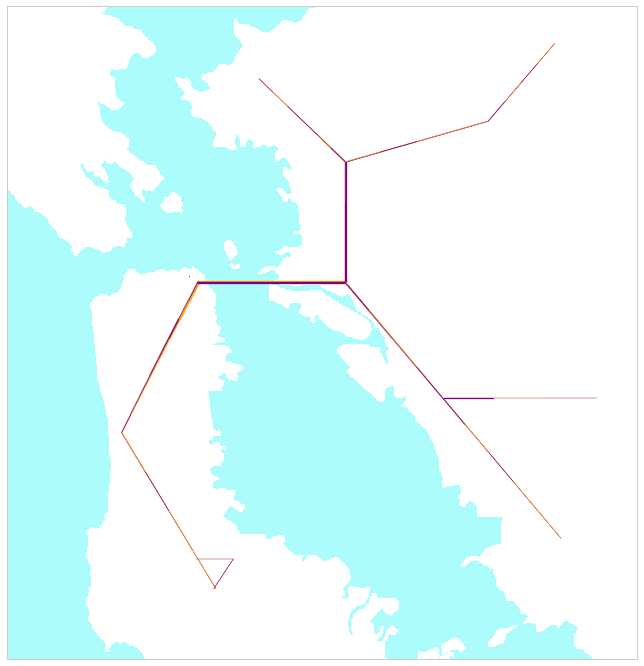

In [695]:
#Ideally, this function for making a gif with matplotlib would have worked. I was having issues and gave up since it is easy enough to make the gif in photoshop for one plot. 

fig, ax = plt.subplots()
#fig.set_tight_layout(True)

datafile = cbook.get_sample_data('/home/pwest/notebooks/BART/sanfrancisco02_bsimple.png')
img = imread(datafile)
ax.imshow(img, zorder=0, extent=[0, 863, 0, 894])
ax.set_xlim(0, 863)
ax.set_ylim(0, 894)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.grid(False)

temp = []
for key in medians['9']:
    temp.append(medians['9'][key])
nine_max = max(temp)

#line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    for station in medians[str(i)]:
       Plot_Connection_Rect(station_coors[station], medians[str(i)][station]/nine_max*30, ax)
    return ax


#for hour in medians:
#    for station in medians[hour]:
#        Plot_Connection_Rect(station_coors[station], medians[hour][station]/nine_max*30, ax)
        
anim = FuncAnimation(fig, update, frames=23, interval=200)
#anim = FuncAnimation(fig, update, frames=23, interval=200)

plt.gcf().set_size_inches(12, 12)
plt.show()